In [137]:
import sys
import numpy as np
from scipy import ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.signal import argrelextrema


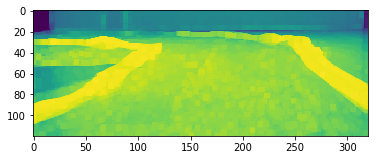

In [138]:
if 1:
    im = ndimage.imread('00.jpg', mode='L')
    im = ndimage.zoom(im[:im.shape[0]/2,:], 0.5)
    im = ndimage.filters.maximum_filter(im, size=(5,5))
else:
    im = ndimage.imread('real.png', mode='L')
    im = ndimage.zoom(im[im.shape[0]/2 + im.shape[0]/10:im.shape[0] - im.shape[0]/10,:], 0.9)
   
plt.imshow(im)

In [139]:
def im_histogram(im):
    p = im.flatten()
    hist = np.zeros(256)
    for x in p:
        hist[int(x)] += 1
    
    return hist
    
def calculate_colors(im, lpf_size=10, lpf_passes=2, plot=None):
    hist = im_histogram(im)
    
    # low pass filter
    w = np.hanning(lpf_size)
    for x in xrange(lpf_passes):
        hist = np.convolve(w/w.sum(), hist)
   
    h = np.column_stack((np.linspace(0, hist.max(), hist.size), hist))

    maxs = argrelextrema(h[:, 1], np.greater, order=10)[0]
    if plot:
        plot.figure(figsize=(13,7))
        plot.subplot(121)
        plot.bar(range(0, hist.size), h[:,1])
        plot.bar(maxs, np.ones(maxs.size)*hist.max())
        plot.subplot(122)

    # find the nearest top color for each color
    def mm(x):
        idx = 0
        m = 25500
        for i, v in enumerate(maxs):
            if abs(v - x) < m: 
                idx = i
                m = abs(v - x)
        return idx

    lookup = np.vectorize(mm)(range(hist.size))
    paletted = np.vectorize(lambda x: lookup[x])(im)
    if plot:
        plot.imshow(paletted)
    
    # calcualte pixels sums
    sums = np.zeros(maxs.size)
    for i, x in enumerate(lookup):
        sums[x] += hist[i]
    
    # sort peaks by the number of colors (likely higher frequencies can be discarded)
    a = np.column_stack((range(0, maxs.size), maxs , hist[maxs], sums, sums/paletted.size))
    maximums = a[a[:, 3].argsort()]
    return maximums, paletted


maximums, paletted = calculate_colors(im)

In [140]:
def extract_lines(image, color_index, plot=None):
    x, y = np.where(image == color_index)
    X = np.column_stack((x, y)) 
    if X.size == 0 or X.shape[0] > image.size * 0.2:
        return []
    try:
        db = DBSCAN(eps=5, min_samples=10).fit(X)
    except ValueError:
        print X
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
   
    coords = []
    for c in set(labels):
        # label -1 means "noise"
        if c != -1:
            class_member_mask = (labels == c)
            coords.append(X[class_member_mask])
    pol = []
    errors = []
    for x in coords:
      try:
          pfd = np.polyfit(x[:,0], x[:, 1], 1)
          bbox = [x[:,0].min(), x[:,0].max(),x[:,1].min(), x[:,1].max()]

          # compute varianze
          xx = np.poly1d(pfd)
          err = (xx(x[:,0]) - x[:,1]).var()
          weight = float(x.shape[0])/im.size
          if weight > 0.0005: 
              pol.append((x, pfd, err, weight))
     
      except ValueError:
          print x


    if plot:
        xp = np.linspace(0, image.shape[0] , 100)
        for c, po, err, weight in pol:
           p = np.poly1d(po)
           _ = plot.plot(c[:,1], c[:, 0], '.', p(xp), xp, '-')

   
    return pol

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RankWarning: Polyfit may be poorly conditioned


(7.294300852715371, 0.0028385416666666667)
(8.1669319504189311, 0.0016927083333333334)
(281.25, 0.0016666666666666668)


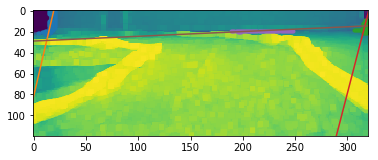

(18.710630843132613, 0.00796875)
(1.1477601156069381, 0.0011458333333333333)


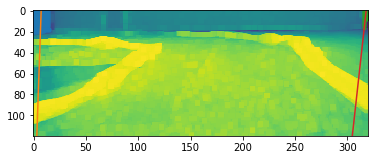

(73.956935174281682, 0.04567708333333333)
(590.14931645233241, 0.06619791666666666)


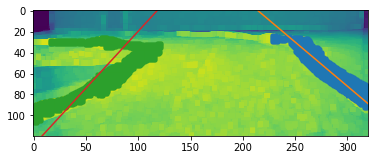

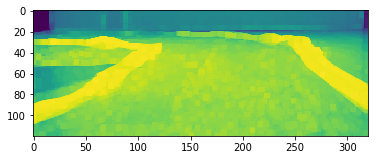

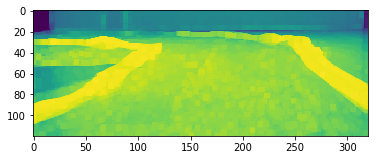

In [141]:
#plt.figure(figsize=(7,4*maximums.size))

for i, x in enumerate(maximums[:,0]):
    fig, ax = plt.subplots()
    ax.imshow(im)
    #ax.imshow(np.random.random((10,10)))
    ax.autoscale(False)
    pols = extract_lines(paletted, x, plot=ax)
    for x in pols:
        print x[2:]
    plt.show()

